<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/Deep_Learning_Silant_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Silant Problem using ViT

I'll use Transfer learning using ViT to detect the defect and normal silant. I'm not sure if I can upload the image to the Googld Drive or not.

In [1]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
print(f"torch version : {torch.__version__}")

torch version : 2.5.0+cpu


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Artificial_Intelligence'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 207 (delta 73), reused 62 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (207/207), 16.53 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
image_path = "/content/drive/MyDrive/data"

In [5]:
# Setup directory paths to train and test images
train_dir = image_path + "/train"
test_dir = image_path + "/test"
print(train_dir, test_dir)

/content/drive/MyDrive/data/train /content/drive/MyDrive/data/test


In [6]:
from torchvision import transforms
from pytorch_modules.pytorch_modules import data_setup

# Create image size
IMG_SIZE = 224  # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our small model)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(60, 14, ['defect', 'normal'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

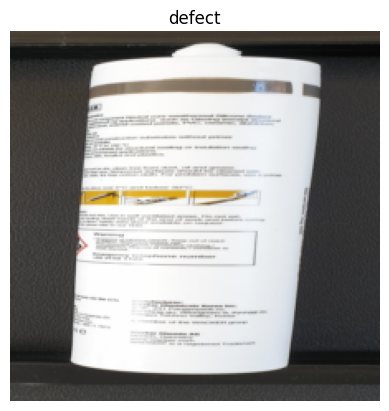

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 228MB/s]


In [11]:
# Create an instance of Transformerblock
summary(model=pretrained_vit,
        input_size = (1,3, 224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 16,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 2]           768              Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)        False
├─Encoder (encoder)                                          [1, 197, 768]    [1, 197, 768]    151,296          False
│    └─Dropout (dropout)                                     [1, 197, 768]    [1, 197, 768]    --               --
│    └─Sequential (layers)                                   [1, 197, 768]    [1, 197, 768]    --               False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]    [1, 197, 768]    (7,087,872)      False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]    [1, 197, 768]    (7,087,872)      False
│    │    └─EncoderBlock (encoder_layer_2)           

In [12]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)


In [ ]:
len(class_names)

In [14]:
from pytorch_modules.pytorch_modules import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3072 | train_acc: 0.8849 | test_loss: 0.2096 | test_acc: 0.9034
Epoch: 2 | train_loss: 0.1648 | train_acc: 0.9344 | test_loss: 0.1337 | test_acc: 0.9561
Epoch: 3 | train_loss: 0.1106 | train_acc: 0.9625 | test_loss: 0.0964 | test_acc: 0.9640
Epoch: 4 | train_loss: 0.0823 | train_acc: 0.9802 | test_loss: 0.0775 | test_acc: 0.9884
Epoch: 5 | train_loss: 0.0645 | train_acc: 0.9859 | test_loss: 0.0630 | test_acc: 0.9955
Epoch: 6 | train_loss: 0.0530 | train_acc: 0.9922 | test_loss: 0.0497 | test_acc: 0.9929
Epoch: 7 | train_loss: 0.0438 | train_acc: 0.9953 | test_loss: 0.0431 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0378 | train_acc: 0.9958 | test_loss: 0.0357 | test_acc: 0.9978
Epoch: 9 | train_loss: 0.0328 | train_acc: 0.9964 | test_loss: 0.0323 | test_acc: 0.9978
Epoch: 10 | train_loss: 0.0285 | train_acc: 0.9974 | test_loss: 0.0272 | test_acc: 0.9978


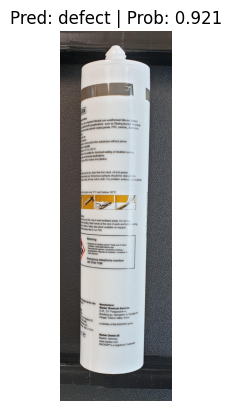

In [27]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
normal_image = "/content/drive/MyDrive/data/test/defect/20240823_110442.jpg"

pred_and_plot_image(model=pretrained_vit,
                           image_path=normal_image,
                           class_names=class_names)